# Laboratorium 3: Augmentacje danych i balans klas (DermaMNIST)


**Cele:**
- porównać wpływ różnych **augmentacji** (geometria, intensywność, heavy) na wyniki,
- zastosować metody **balansu klas**: wagi w `CrossEntropy`, `WeightedRandomSampler`,
- przeprowadzić rzetelną **ewaluację** (Loss, Accuracy, Macro-Precision/Recall/F1, Confusion Matrix),
- zebrać wyniki w tabeli i wyciągnąć wnioski.

> **Dataset:** **DermaMNIST (MedMNIST)** – 7-klasowa klasyfikacja zmian skórnych, automatyczny download.

> Uwaga: architektura CNN będzie prosta (dla 28×28×3); skupiamy się na augmentacjach i balansie klas.

Augmentacja danych (ang. data augmentation) to zestaw technik sztucznego powiększania i urozmaicania zbioru treningowego poprzez modyfikacje istniejących danych. Istniejące próbki przekształca się tak, aby powstały ich różnorodne warianty, ale zachowujące tę samą etykietę (klasę). Przykłady dla obrazów:
- obrót, odbicie lustrzane, przycięcie, skalowanie, przesunięcie,
- zmiana jasności, kontrastu, koloru, dodanie szumu,
- losowe maskowanie fragmentów obrazu (Cutout, Random Erasing).

Stosowana jest ona w celu: zwiększenia rozmiaru zbioru treningowego – szczególnie ważne, gdy mamy mało przykładów, poprawy generalizacji – model uczy się odporniejszych cech (mniejszy overfitting), symulacji warunków rzeczywistych – różne oświetlenia, kąty patrzenia czy szumy w danych, wyrównania zbioru – generowanie dodatkowych przykładów dla klas, których jest mniej.

## 0) Instalacja i importy

In [2]:
# !pip -q install medmnist torchmetrics tqdm scikit-learn pandas

import os, random, math, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
from tqdm.auto import tqdm

from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             confusion_matrix, ConfusionMatrixDisplay)

import medmnist
from medmnist import DermaMNIST, INFO

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
set_seed()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.9/115.9 kB 13.1 MB/s eta 0:00:00
Device: cuda


## 1) Pobranie danych (DermaMNIST, MedMNIST) + szybki podgląd i rozkład klas

Skrypt automatycznie pobiera zbiór **DermaMNIST**. Poniższy kod sprawdza rozmiar danych i etykiety.
Wyświetlone zostaje również 6 pierwszych próbek z tego zbioru.

Zwróć uwagę na rozkład klas w wykorzystywanym zbiorze. Co można o nim powiedzieć?

Opis: The DermaMNIST is based on the HAM10000, a large collection of multi-source dermatoscopic images of common pigmented skin lesions. The dataset consists of 10,015 dermatoscopic images categorized as 7 different diseases, formulized as a multi-class classification task. We split the images into training, validation and test set with a ratio of 7:1:2. The source images of 3×600×450 are resized into 3×28×28.
Liczba klas: 7 ; label map: {'0': 'actinic keratoses and intraepithelial carcinoma', '1': 'basal cell carcinoma', '2': 'benign keratosis-like lesions', '3': 'dermatofibroma', '4': 'melanoma', '5': 'melanocytic nevi', '6': 'vascular lesions'}


100%|██████████| 19.7M/19.7M [00:12<00:00, 1.59MB/s]


Rozmiary: 7007 1003 2005


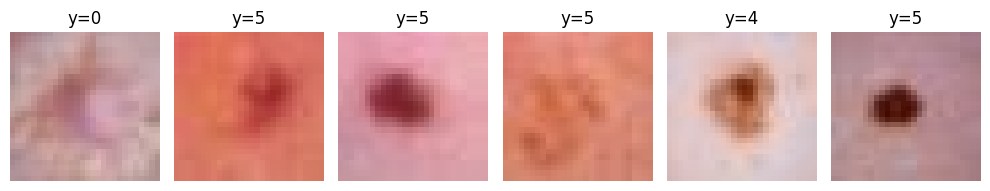

Rozkład klas (train): {0: 228, 1: 359, 2: 769, 3: 80, 4: 779, 5: 4693, 6: 99}


In [4]:
DATA_ROOT = './data/dermamnist'
os.makedirs(DATA_ROOT, exist_ok=True)
info = INFO['dermamnist']
NUM_CLASSES = len(info['label'])
print('Opis:', info['description'])
print('Liczba klas:', NUM_CLASSES, '; label map:', info['label'])

# as_rgb=True -> 3 kanały
train_raw = DermaMNIST(split='train', download=True, root=DATA_ROOT, as_rgb=True)
val_raw   = DermaMNIST(split='val',   download=True, root=DATA_ROOT, as_rgb=True)
test_raw  = DermaMNIST(split='test',  download=True, root=DATA_ROOT, as_rgb=True)
print('Rozmiary:', len(train_raw), len(val_raw), len(test_raw))

# podgląd kilku przykładów
fig, axes = plt.subplots(1, 6, figsize=(10,2))
for i in range(6):
    img, y = train_raw[i]
    axes[i].imshow(np.array(img))
    axes[i].set_title(f'y={int(y.squeeze().item())}')
    axes[i].axis('off')
plt.tight_layout(); plt.show()

# Rozkład klas w train
vals, cnts = np.unique(train_raw.labels.squeeze(), return_counts=True)
print('Rozkład klas (train):', dict(zip(vals.tolist(), cnts.tolist())))

## Zadanie 1 – Dataset z przełączanymi augmentacjami i normalizacją

W następnym fragmencie kodu chcemy przygotować różn warianty augmentacji danych, które będą wykorzystane do uczenia sieci i porównania wyników. W tym celu korzystamy z klasy `transforms` z biblioteki `torchvision`.

1. Przygotuj najprostszą, bazową transformację danych. Zawiera ona przekształcenia, które będą obecne we wszystkich innych wariantach augmentacji.
2. Do stworzenia pojedynczego wariantu wykorzystujemy funkcję `transforms.Compose`. Przyjmuje ona listę transformacji, które powinny być wykonane na wczytywanych danych.
3. Podstawowy wariant powinien zawierać dwie transformacje: `transforms.ToTensor()` i `transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5])`. Pierwsza z nich przekształca dane do typu tensora z PyTorch z odpowiednią kolejnością wymiarów. Dodatkowo dla obrazów typu `uint8` zmienia ich zakres do `[0.0, 1.0]`. Jeśli wejściem są wartości typu `float`, to zostaną one zachowane. Druga z kolei zmienia zakres danych do przedziału `[-1.0, 1.0]` (zakłądając, że wejście ma zakres `[0.0, 1.0]`). Jej arguemntami są paramtry normalizacji dla poszczególnych kanałów.
4. Stwórz transformację, która przed bazowymi wykona dodatkowo odbicie w poziomie `transforms.RandomHorizontalFlip` i rotację obrazu `transforms.RandomRotation`. Argumentem pierwszej jest prawdopodobieństwo odbicia, a drugiej maksymalny kąt rotacji w stopniach.
5. Stwórz transformację, która przed bazowymi wykona dodatkowo losową zmianę kolorów `transforms.ColorJitter`. Argumentami są maksymalne zmiany dla danej właściwości, np. `transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02)`.
6. Czwarta transformacja powinna łączyć wszystkie wymienione wcześniej.
7. Napisz również funkcję `make_datasets`, która będzie tworzyć DataSet i aplikować transformacje przekazane jako argument do danych treningowych. Zwracać powinna 3 zbiory danych: treningowy, walidacyjny i testowy. Dla danych walidacyjnych i testowych stosujemy tylko podstawowy wariant transformacji. Transformacja jest przekazywana jako dodatkowy arguement podczas inicjalizacji obiektu klasy `DermaMNIST`.
8. Zdefiniuj `BATCH_SIZE`, `NUM_WORKERS` i `PIN_MEMORY`.

In [5]:
# Zadanie 1

BATCH_SIZE = 64
NUM_WORKERS = 2
PIN_MEMORY = True
EPOCHS     = 12

base_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

flip_rotate_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

color_jitter_transform = transforms.Compose([
    transforms.ColorJitter(brightness=0.1, contrast=0.1,
                           saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

combined_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1,
                           saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

def make_datasets(train_transform):
    train = DermaMNIST(split='train', transform=train_transform, download=True)
    val = DermaMNIST(split='val', transform=base_transform, download=True)
    test = DermaMNIST(split='test', transform=base_transform, download=True)
    return train, val, test

if __name__ == "__main__":
    train_set, val_set, test_set = make_datasets(combined_transform)

    train_loader = torch.utils.data.DataLoader(
        train_set, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    val_loader = torch.utils.data.DataLoader(
        val_set, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    test_loader = torch.utils.data.DataLoader(
        test_set, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    print(len(train_loader), len(val_loader), len(test_loader))


100%|██████████| 19.7M/19.7M [00:02<00:00, 8.43MB/s]


110 16 32


## Zadanie 2 – Prosta sieć CNN 3-kanałowa + pętle trening/ewaluacja

Zdefniujmy bardzo podobną sieć do wykorzystanej w poprzednim tygodniu. Poniżej znajduje się lista modyfikacji koniecznych do wykonania.

1. Liczba kanałów wejściowych: 3.
2. Liczba kanałów wyjściowych pierwszej warstwy konwolucyjnej: 16.
3. Liczba kanałów wyjściowych drugiej warstwy konwolucyjnej: 32.
4. Rozmiar obu konwolucji wynosi 3, a padding 1.
5. Wyjście pierwszej warstwy w pełni połączonej ma rozmiar 128.
6. Liczba klas (a więc i rozmiar wyjścia sieci) powinna być podawana jako argument.
7. Dodajmy również warstwę dropout o prawdopodobieństwie równym 0.25 `nn.Dropout(p=0.25)` pomiędzy warstwami w pełni połączonymi. Warstwa ta losowo wyłącza część neuronów z zadanym prawdopodobieństwem. Warstwa taka może poprawić generalizację sieci i sprawić, że będzie się uczyć bardziej ogólnych cech.
8. Zaimplementuj funkcję, która będzie wykonywać jedną epokę treningu (podobnie jak w poprzednim ćwiczeniu). Jej argumentami są trenowana sieć, DataLoader, optimalizator i obiekt funkcji straty. Nie musi ona liczyć dokładności, bo zaimplementujemy osobną funkcję do ewaluacji.
9. Zaimplementuj funkcję wykonującą ewaluację sieci. Jak argumenty przyjmuje ona instancję sieci i DataLoader. Zapamiętaj w dwóch listach predykcje sieci i etykiety. Po przetworzeniu danych połącz je w jeden wektor za pomocą funkcji `np.concatenate` i oblicz metryki klasyfikacji takie jak: dokładność (accuracy), precyzja (precision), czułość (recall) i F1-score. W tym calu wykozystaj funkcje `accuracy_score`, `precision_score`, `recall_score` i `f1_score`.
    - Dokładność jest odsetkiem poprawnie sklasyfikowanych próbek.
    - Precyzja mówi ile z przewidzianych klasyfikacji danej klasy naprawdę należało do danej klasy. Dodajemy argument `average='macro`, który sprawia, że finalny wynik jest uśrednioną wartością dla wszystkich klas.
    - Czułość mówi ile z prawdziwych przykładów danej klasy zostało poprawnie znalezionych przez model. W tym przypadku również chcemy uśrednić wyniki dla wszystkich klas.
    - F1-score jest średnią harmoniczną z precyzji i czułości. Również chcemy go uśrednić dla wszystkich klas.
Na wyjście sieci przekaż słownik zawierający obliczone metryki, wektor predykcji sieci oraz wektor rzeczywistych etykiet.

Dlaczego w przypadku wykorzystywanego zbioru po prostu sprawdzanie dokładności może nie być dobrą metodą oceny jej skuteczności?

In [6]:
# Zadanie 2

class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # zakładając wejście 28x28
        self.dropout = nn.Dropout(p=0.25)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, labels in dataloader:
        images, labels = images.to(device), labels.squeeze().to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
    return running_loss / len(dataloader.dataset)

def evaluate(model, dataloader, device):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.squeeze().to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    y_pred = np.concatenate(all_preds)
    y_true = np.concatenate(all_labels)

    metrics = {
        'accuracy': accuracy_score(y_true, y_pred),
        'precision': precision_score(y_true, y_pred, average='macro', zero_division=0),
        'recall': recall_score(y_true, y_pred, average='macro', zero_division=0),
        'f1_score': f1_score(y_true, y_pred, average='macro', zero_division=0)
    }

    return metrics, y_pred, y_true


## Zadanie 3 – Przeprowadzenie treningu i sprawdzenie augmentacji

Przeprowadź trening zdefiniowanej sieci dla każdego z wariantów augmentacji danych treningowych. Dla wielu przypadków testowych dobrze jest stworzyć strukturę zawierającą scenariusze testowe i uruchomić je w pętli.

1. Dla każdego pzypadku stwórz 3 DataSety z odpowiednimi transformacjami (użyj przygotowanej wcześniej funkcji), a następnie dla każdego z nich DataLoader.
2. Dla każdego przypadku stwórz instancję trenowanej sieci, optymalizator `torch.optim.Adam` i funkcję straty `nn.CrossEntropyLoss`.
3. Stwórz puste listy do śledzenia postępu treningu: `train_losses`, `val_losses`, `train_accuracies`, `val_accuracies`, `val_f1_scores`, `epochs_list`.
4. Dodatkowo chcemy zapamiętać model, który dla danego treningu osiągnął najlepszą wartość metryki F1-macro. Wymaga to zapamiętania najlepszej do tej pory widzianej metryki i poprawnej inicjalizacji.
5. Napisz pętlę trenującą. W każdej iteracji chcemy:
    - wykonać epokę treningu,
    - obliczyć i zapamiętać metryki dla zbioru treningowego,
    - obliczyć i zapamiętać metryki dla zbioru walidacyjnego,
    - obliczyć i zapamiętać stratę dla zbioru treningowego,
    - obliczyć i zapamiętać stratę dla zbioru walidacyjnego,
    - sprawdzić czy jest to najlepszy do tej pory model,
    - (opcjonalnie) wyświetlać wyniki po każdej epoce.
6. Po zakończonym treningu wyświetl 2 wykresy:
    - wykres staty dla zbioru treningowego i walidacyjnego,
    - wykres wyznaczonych metryk dla zbioru treningowego i walidayjnego.
7. Wykonaj ewaluację dla zbioru testowego. Wyświetl macierz pomyłek (podobnie jak w poprzednim ćwiczeniu).

Dobrze jest zapamiętywać wyniki metryki zbioru testowego dla wszystkich testowanych przypadków i wyświetlić je na końcu w formie tabeli.


=== Trenowanie dla wariantu: base ===
Epoka 1: train_loss=1.0181, val_loss=0.8884, train_acc=0.683, val_acc=0.680, val_f1=0.150
Epoka 2: train_loss=0.8631, val_loss=0.8040, train_acc=0.705, val_acc=0.704, val_f1=0.233
Epoka 3: train_loss=0.8143, val_loss=0.7672, train_acc=0.706, val_acc=0.708, val_f1=0.247
Epoka 4: train_loss=0.7901, val_loss=0.7525, train_acc=0.712, val_acc=0.714, val_f1=0.285
Epoka 5: train_loss=0.7612, val_loss=0.7335, train_acc=0.727, val_acc=0.724, val_f1=0.340
Epoka 6: train_loss=0.7415, val_loss=0.7092, train_acc=0.741, val_acc=0.731, val_f1=0.379
Epoka 7: train_loss=0.7211, val_loss=0.7130, train_acc=0.738, val_acc=0.729, val_f1=0.387
Epoka 8: train_loss=0.7110, val_loss=0.7320, train_acc=0.739, val_acc=0.736, val_f1=0.442
Epoka 9: train_loss=0.6970, val_loss=0.6823, train_acc=0.757, val_acc=0.756, val_f1=0.442
Epoka 10: train_loss=0.6796, val_loss=0.6783, train_acc=0.765, val_acc=0.751, val_f1=0.451
Epoka 11: train_loss=0.6688, val_loss=0.6714, train_acc=0.76

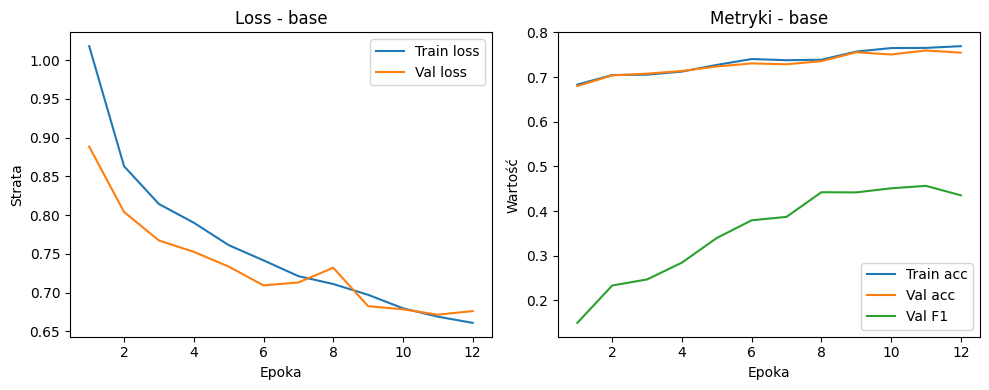

Wyniki testowe (base): {'accuracy': 0.74214463840399, 'precision': 0.49438963632194116, 'recall': 0.42546470295156275, 'f1_score': 0.4319542159322342}


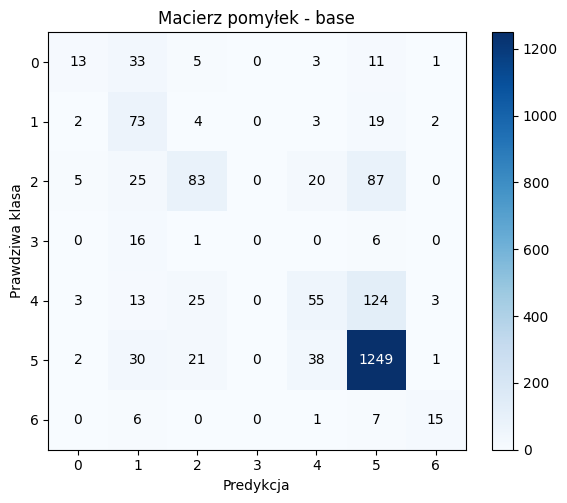


=== Trenowanie dla wariantu: flip+rotate ===
Epoka 1: train_loss=1.0460, val_loss=0.9238, train_acc=0.671, val_acc=0.670, val_f1=0.120
Epoka 2: train_loss=0.8999, val_loss=0.8664, train_acc=0.688, val_acc=0.678, val_f1=0.156
Epoka 3: train_loss=0.8444, val_loss=0.7985, train_acc=0.699, val_acc=0.691, val_f1=0.206
Epoka 4: train_loss=0.8188, val_loss=0.7775, train_acc=0.704, val_acc=0.709, val_f1=0.255
Epoka 5: train_loss=0.7886, val_loss=0.7535, train_acc=0.713, val_acc=0.713, val_f1=0.271
Epoka 6: train_loss=0.7656, val_loss=0.7324, train_acc=0.719, val_acc=0.724, val_f1=0.360
Epoka 7: train_loss=0.7560, val_loss=0.7281, train_acc=0.714, val_acc=0.710, val_f1=0.314
Epoka 8: train_loss=0.7356, val_loss=0.7128, train_acc=0.729, val_acc=0.724, val_f1=0.357
Epoka 9: train_loss=0.7306, val_loss=0.7080, train_acc=0.740, val_acc=0.746, val_f1=0.399
Epoka 10: train_loss=0.7173, val_loss=0.7068, train_acc=0.732, val_acc=0.728, val_f1=0.363
Epoka 11: train_loss=0.7122, val_loss=0.6858, train_a

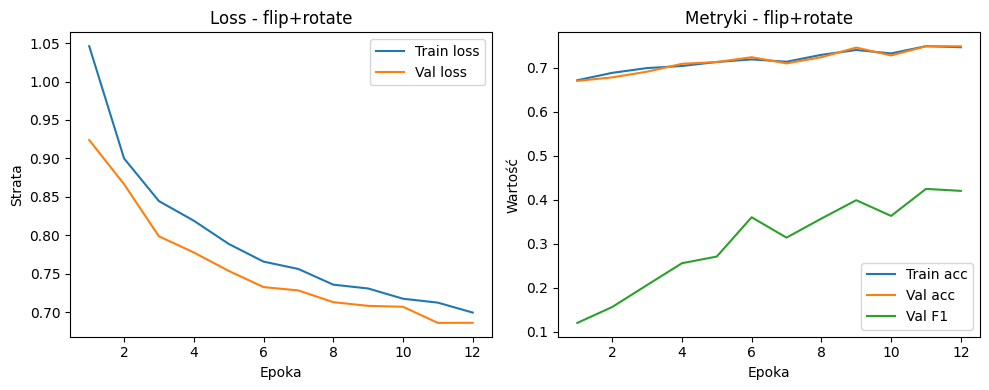

Wyniki testowe (flip+rotate): {'accuracy': 0.7261845386533666, 'precision': 0.4493645768497216, 'recall': 0.3844033126298955, 'f1_score': 0.397378325229682}


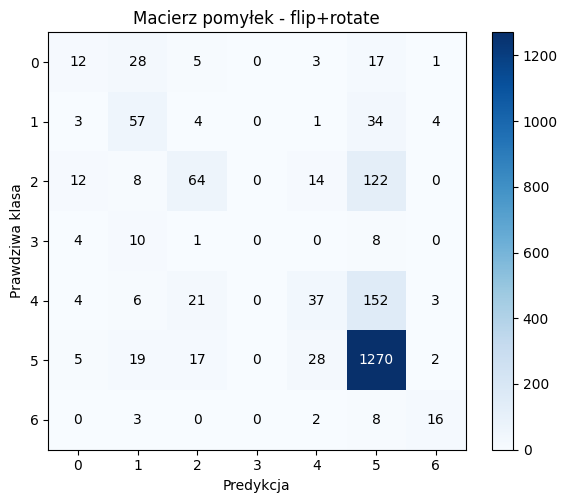


=== Trenowanie dla wariantu: color_jitter ===
Epoka 1: train_loss=1.0412, val_loss=0.9182, train_acc=0.669, val_acc=0.673, val_f1=0.129
Epoka 2: train_loss=0.9026, val_loss=0.8470, train_acc=0.688, val_acc=0.682, val_f1=0.169
Epoka 3: train_loss=0.8598, val_loss=0.7961, train_acc=0.704, val_acc=0.712, val_f1=0.257
Epoka 4: train_loss=0.8273, val_loss=0.7694, train_acc=0.716, val_acc=0.715, val_f1=0.291
Epoka 5: train_loss=0.7982, val_loss=0.7425, train_acc=0.718, val_acc=0.724, val_f1=0.315
Epoka 6: train_loss=0.7759, val_loss=0.7197, train_acc=0.734, val_acc=0.735, val_f1=0.367
Epoka 7: train_loss=0.7592, val_loss=0.7065, train_acc=0.739, val_acc=0.735, val_f1=0.372
Epoka 8: train_loss=0.7393, val_loss=0.7042, train_acc=0.747, val_acc=0.761, val_f1=0.446
Epoka 9: train_loss=0.7283, val_loss=0.6991, train_acc=0.746, val_acc=0.748, val_f1=0.413
Epoka 10: train_loss=0.7247, val_loss=0.7072, train_acc=0.738, val_acc=0.729, val_f1=0.344
Epoka 11: train_loss=0.7053, val_loss=0.6871, train_

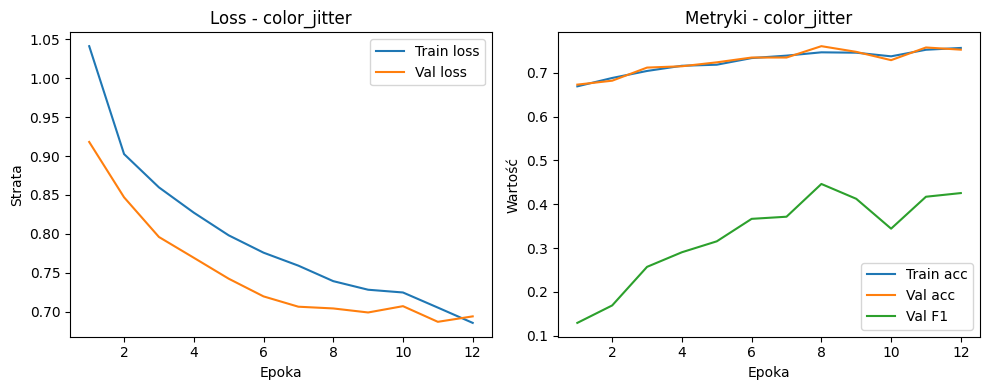

Wyniki testowe (color_jitter): {'accuracy': 0.7351620947630922, 'precision': 0.4794750481231017, 'recall': 0.3987865478692338, 'f1_score': 0.420755893405356}


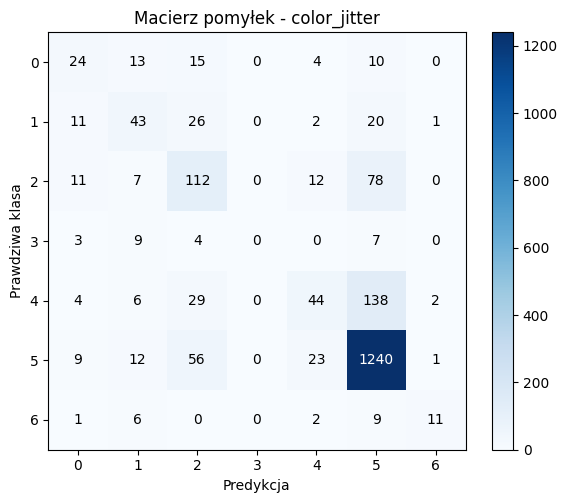


=== Trenowanie dla wariantu: combined ===
Epoka 1: train_loss=1.0327, val_loss=0.9198, train_acc=0.674, val_acc=0.672, val_f1=0.130
Epoka 2: train_loss=0.9053, val_loss=0.8412, train_acc=0.689, val_acc=0.691, val_f1=0.200
Epoka 3: train_loss=0.8674, val_loss=0.8127, train_acc=0.698, val_acc=0.690, val_f1=0.209
Epoka 4: train_loss=0.8543, val_loss=0.7894, train_acc=0.705, val_acc=0.706, val_f1=0.247
Epoka 5: train_loss=0.8192, val_loss=0.7738, train_acc=0.712, val_acc=0.717, val_f1=0.292
Epoka 6: train_loss=0.8005, val_loss=0.7414, train_acc=0.721, val_acc=0.720, val_f1=0.318
Epoka 7: train_loss=0.7759, val_loss=0.7176, train_acc=0.725, val_acc=0.730, val_f1=0.362
Epoka 8: train_loss=0.7662, val_loss=0.7142, train_acc=0.732, val_acc=0.726, val_f1=0.335
Epoka 9: train_loss=0.7583, val_loss=0.7270, train_acc=0.732, val_acc=0.735, val_f1=0.405
Epoka 10: train_loss=0.7484, val_loss=0.7056, train_acc=0.741, val_acc=0.740, val_f1=0.394
Epoka 11: train_loss=0.7324, val_loss=0.7240, train_acc=

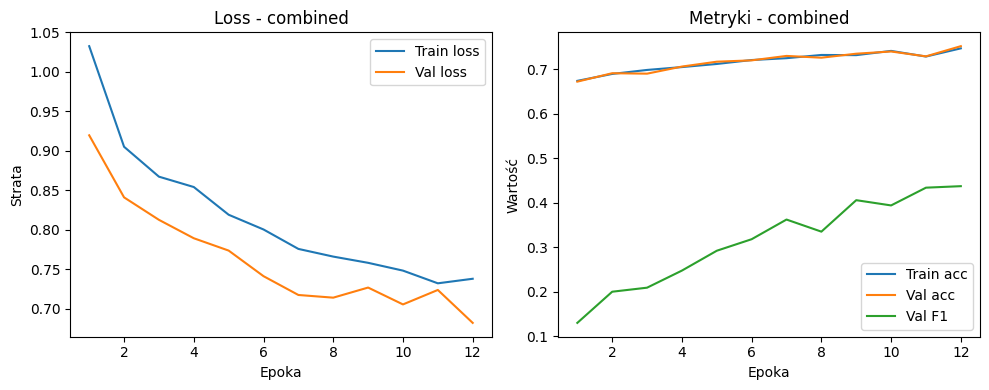

Wyniki testowe (combined): {'accuracy': 0.7461346633416459, 'precision': 0.49012052029876035, 'recall': 0.4187934830763696, 'f1_score': 0.4437580951499952}


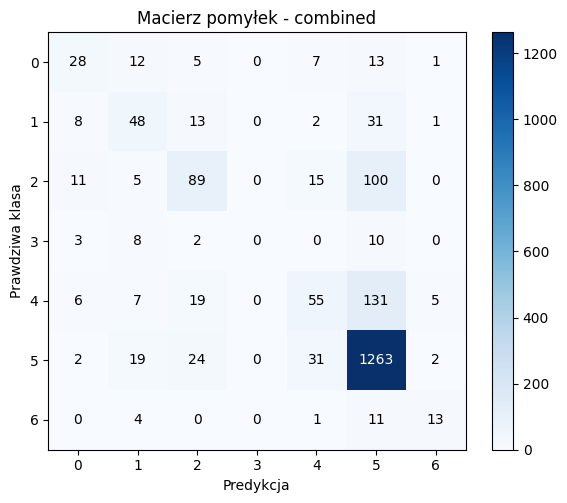


=== Wyniki końcowe na zbiorze testowym ===
    Augmentacja  Accuracy  Precision    Recall  F1-score
0          base  0.742145   0.494390  0.425465  0.431954
1   flip+rotate  0.726185   0.449365  0.384403  0.397378
2  color_jitter  0.735162   0.479475  0.398787  0.420756
3      combined  0.746135   0.490121  0.418793  0.443758


In [7]:
# Zadanie 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

scenarios = {
    "base": base_transform,
    "flip+rotate": flip_rotate_transform,
    "color_jitter": color_jitter_transform,
    "combined": combined_transform
}

results = []

for name, transform in scenarios.items():
    print(f"\n=== Trenowanie dla wariantu: {name} ===")

    train_set, val_set, test_set = make_datasets(transform)
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                              num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    num_classes = len(np.unique(train_set.labels))
    model = SimpleCNN(num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accuracies, val_accuracies, val_f1_scores = [], [], []
    epochs_list = []
    best_f1 = 0.0
    best_model_state = None

    for epoch in range(1, EPOCHS + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        train_metrics, _, _ = evaluate(model, train_loader, device)
        val_metrics, _, _ = evaluate(model, val_loader, device)

        # Poprawne liczenie walidacyjnej straty
        val_loss = 0.0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.squeeze().to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                total += images.size(0)
        val_loss /= total

        # Zapis metryk
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_metrics['accuracy'])
        val_accuracies.append(val_metrics['accuracy'])
        val_f1_scores.append(val_metrics['f1_score'])
        epochs_list.append(epoch)

        if val_metrics['f1_score'] > best_f1:
            best_f1 = val_metrics['f1_score']
            best_model_state = model.state_dict()

        print(f"Epoka {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_acc={train_metrics['accuracy']:.3f}, val_acc={val_metrics['accuracy']:.3f}, "
              f"val_f1={val_metrics['f1_score']:.3f}")


    model.load_state_dict(best_model_state)

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.plot(epochs_list, train_losses, label='Train loss')
    plt.plot(epochs_list, val_losses, label='Val loss')
    plt.title(f'Loss - {name}')
    plt.xlabel('Epoka'); plt.ylabel('Strata'); plt.legend()

    plt.subplot(1,2,2)
    plt.plot(epochs_list, train_accuracies, label='Train acc')
    plt.plot(epochs_list, val_accuracies, label='Val acc')
    plt.plot(epochs_list, val_f1_scores, label='Val F1')
    plt.title(f'Metryki - {name}')
    plt.xlabel('Epoka'); plt.ylabel('Wartość'); plt.legend()
    plt.tight_layout()
    plt.show()

    test_metrics, y_pred, y_true = evaluate(model, test_loader, device)
    print(f"Wyniki testowe ({name}): {test_metrics}")

    # macierz pomyłek
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Macierz pomyłek - {name}')
    plt.colorbar()
    plt.xlabel('Predykcja')
    plt.ylabel('Prawdziwa klasa')

    # Add text annotations
    num_classes = cm.shape[0]
    for i in range(num_classes):
        for j in range(num_classes):
            plt.text(j, i, str(cm[i, j]),
                    ha='center', va='center',
                    color='white' if cm[i, j] > cm.max()/2 else 'black')

    plt.tight_layout()
    plt.show()

    results.append({
        "Augmentacja": name,
        "Accuracy": test_metrics['accuracy'],
        "Precision": test_metrics['precision'],
        "Recall": test_metrics['recall'],
        "F1-score": test_metrics['f1_score']
    })

    del train_loader, val_loader, test_loader, train_set, val_set, test_set
    torch.cuda.empty_cache()


results_df = pd.DataFrame(results)
print("\n=== Wyniki końcowe na zbiorze testowym ===")
print(results_df)


## Zadanie 4 – Balans klas: wagi, WeightedRandomSampler

Wykorzystamy dodatkowo dwie metody radzenia sobie ze zbiorami danych i niezbalansowanych klasach.
Pierwszą są wagi klas (class weights). Działa to w ten sposób, że jeśli jakaś klasa jest rzadka, to jej błędy mają być bardziej kosztowne. Dodając większe wagi dla rzadkich klas w funkcji straty, uczymy model, żeby przykładał do nich większą wagę.

Drugą metodą jest zmiana doboru próbek (WeightedRandomSampler). W tym przypadku rzadkie klasy są częściej losowane do batcha, a więc model widzi ich proporcjonalnie więcej. Również w tym przypadku tworzymy wagi dla każdej klasy.

1. Zaimplementuj funkcję, która będzie obliczać wagi dla klas. Jej argumentem jest lista rzeczywistych etykiet zbioru treningowego (metoda `.labels` dla zbioru treningowego).
2. Wewnątrz funkcji sprawdzamy ile jest wystąpień dla każdej etykiety (funkcja `np.unique`). Jej pierwszym argumentem są etykiety. Przekazujemy jej również argument `return_counts=True`, który powoduje, że funkcja zwraca również liczbę wystąpień.
3. Następnie dzielimy otrzymane wystąpienia przez liczbę próbek. W ten sposób obliczamy częstość występowania danej klasy.
4. Chcemy, aby waga była odwrotnie proporcjonalna do częstości jej występowania, a więc obliczamy odwrotność poprzedniej wartości. Warto dodać zabezpieczenie przed zbyt małą wartością mianownika `np.maximum(freq, 1e-8)`.
5. Normalizujemy wartości obliczonych wag tak, żeby ich suma wynosiła liczbę możliwych etykiet.
6. Zwracamy tensor wag `torch.tensor` z danymi typu `torch.float32`.
7. Wyświetl obliczone wagi.
8. Na podstawie wag zwróconych przez zaimplementowaną funkcję stworzymy sampler do danych treningowych. W tym celu należy obliczyć wagę dla każdej próbki ze zbioru treningowego. Bierzemy więc listę etykiet próbek i sprawdzamy jakie prawdopodobieństwo odpowiada każdej z nich (a więc robimy Look-Up Table).
9. Obliczone nagi dla każdej próbki przezkazujemy do klasy `WeightedRandomSampler` jako argument `weights`. Oprócz tego konieczne jst przekazanie argumentu `num_samples`, czyli liczba próbek, i podanie argumentu `replacement` jako `True`.

In [8]:
# Zadanie 4
train_set, val_set, test_set = make_datasets(transform)

def compute_class_weights(labels):
    labels = np.array(labels).squeeze()  # upewniamy się, że jest 1D
    classes, counts = np.unique(labels, return_counts=True)

    # częstość występowania klasy
    freq = counts / len(labels)

    # waga odwrotna do częstości
    weights = 1.0 / np.maximum(freq, 1e-8)

    # normalizacja tak, aby suma wag = liczba klas
    weights = weights * len(classes) / np.sum(weights)

    return torch.tensor(weights, dtype=torch.float32)

# Compute class weights
class_weights = compute_class_weights(train_set.labels)

# Tensor of labels
train_labels = torch.tensor(np.array(train_set.labels).squeeze(), dtype=torch.long)

# Sample weights for each example
sample_weights = class_weights[train_labels]

# WeightedRandomSampler
sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

## Zadanie 5 – Przeprowadzenie treningu i sprawdzenie wpływu testowanych metod na wynik

Przeprowadzamy trening podobno do zadania 3, ale tym razem zamiast metod augumentacji sprawdzamy wpływ wag strat i częstości doboru próbek.

1. Aby sprawdzić wpływ wag, do funkcji straty należy przekazać ich wektor `nn.CrossEntropyLoss(weight=weights_ce.to(device))`.
2. Aby sprawdzić wpływ samplera, należy go przekazać do DataLoadera jako argument `sampler`.
3. Sprawdź wpływ zaimplementowanych metod na wyniki treningu przeprowadzając eksperymenty w podobny sposób jak w zadaniu 3.

In [9]:
# Zadanie 5


scenarios = {
    "baseline": {"use_weights": False, "use_sampler": False},
    "class_weights": {"use_weights": True, "use_sampler": False},
    "sampler": {"use_weights": False, "use_sampler": True},
    "weights+sampler": {"use_weights": True, "use_sampler": True}
}

def prepare_train_loader(train_set, use_sampler=False, weights=None):
    if use_sampler:
        # upewniamy się, że weights to tensor
        assert weights is not None, "Musisz przekazać tensor wag, jeśli używasz sampler-a"
        train_labels = torch.tensor(np.array(train_set.labels).squeeze(), dtype=torch.long)
        sample_weights = weights[train_labels]
        sampler = torch.utils.data.WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        return DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    else:
        return DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

def get_criterion(use_weights=False, weights=None):
    if use_weights:
        return nn.CrossEntropyLoss(weight=weights.to(device))
    else:
        return nn.CrossEntropyLoss()

for name, config in scenarios.items():
    print(f"\n=== Trening: {name} ===")

    # --- Dane ---
    train_set, val_set, test_set = make_datasets(base_transform)

    # Compute class weights tensor
    weights_ce = compute_class_weights(train_set.labels)

    # Train loader

    train_loader = prepare_train_loader(
    train_set,
    use_sampler=config["use_sampler"],
    weights=weights_ce if (config["use_sampler"] or config["use_weights"]) else None
    )
    val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False,
                            num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
    test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False,
                             num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

    # --- Model i loss ---
    num_classes = len(np.unique(train_set.labels))
    model = SimpleCNN(num_classes).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    criterion = get_criterion(use_weights=config["use_weights"], weights=weights_ce)

    # --- Monitorowanie ---
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies, val_f1_scores = [], [], []
    best_f1 = 0.0
    best_model_state = None

    # --- Pętla epok ---
    for epoch in range(1, EPOCHS + 1):
        train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
        train_metrics, _, _ = evaluate(model, train_loader, device)
        val_metrics, _, _ = evaluate(model, val_loader, device)

        # Poprawne liczenie walidacyjnej straty
        val_loss = 0.0
        total = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.squeeze().to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                total += images.size(0)
        val_loss /= total

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_metrics['accuracy'])
        val_accuracies.append(val_metrics['accuracy'])
        val_f1_scores.append(val_metrics['f1_score'])

        if val_metrics['f1_score'] > best_f1:
            best_f1 = val_metrics['f1_score']
            best_model_state = model.state_dict()

        print(f"Epoka {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_acc={train_metrics['accuracy']:.3f}, val_acc={val_metrics['accuracy']:.3f}, "
              f"val_f1={val_metrics['f1_score']:.3f}")

    # --- Załaduj najlepszy model ---
    model.load_state_dict(best_model_state)

    # --- Ewaluacja testowa ---
    test_metrics, y_pred, y_true = evaluate(model, test_loader, device)
    print(f"Wyniki testowe ({name}): {test_metrics}")

    results.append({
        "Method": name,
        "Accuracy": test_metrics['accuracy'],
        "Precision": test_metrics['precision'],
        "Recall": test_metrics['recall'],
        "F1-score": test_metrics['f1_score']
    })

    # --- Czyszczenie pamięci ---
    del train_loader, val_loader, test_loader, train_set, val_set, test_set, model
    torch.cuda.empty_cache()

# --- Wyniki końcowe ---
results_df = pd.DataFrame(results)
print("\n=== Porównanie metod na zbiorze testowym ===")
print(results_df)



=== Trening: baseline ===
Epoka 1: train_loss=1.0395, val_loss=0.9110, train_acc=0.680, val_acc=0.674, val_f1=0.137
Epoka 2: train_loss=0.8914, val_loss=0.8412, train_acc=0.699, val_acc=0.699, val_f1=0.215
Epoka 3: train_loss=0.8375, val_loss=0.7969, train_acc=0.706, val_acc=0.707, val_f1=0.272
Epoka 4: train_loss=0.7992, val_loss=0.7767, train_acc=0.718, val_acc=0.718, val_f1=0.302
Epoka 5: train_loss=0.7695, val_loss=0.7507, train_acc=0.722, val_acc=0.722, val_f1=0.293
Epoka 6: train_loss=0.7489, val_loss=0.7334, train_acc=0.727, val_acc=0.725, val_f1=0.320
Epoka 7: train_loss=0.7306, val_loss=0.7353, train_acc=0.745, val_acc=0.726, val_f1=0.410
Epoka 8: train_loss=0.7254, val_loss=0.7143, train_acc=0.739, val_acc=0.735, val_f1=0.381
Epoka 9: train_loss=0.7022, val_loss=0.6853, train_acc=0.759, val_acc=0.754, val_f1=0.429
Epoka 10: train_loss=0.6862, val_loss=0.6890, train_acc=0.763, val_acc=0.750, val_f1=0.452
Epoka 11: train_loss=0.6740, val_loss=0.6848, train_acc=0.756, val_acc=0

## Zadanie 6 – Eksperymenty własne

Spróbuj połączyć poznane metody tak, aby uzysać jak największy wskaźnik F1-macro. Możesz dodatkowo użyć innych metod augmentacji danych, takich jak: `transforms.RandomVerticalFlip`, `transforms.RandomAffine`, `transforms.RandomResizedCrop`, `transforms.GaussianBlur`, `transforms.RandomApply`, `transforms.RandomAdjustSharpness`, `transforms.RandomGrayscale`, `transforms.RandomErasing`, `transforms.Lambda` (może zostać użyte do uzyskania szumu Gaussowskiego: `transforms.Lambda(lambda x: torch.clamp(x + 0.03*torch.randn_like(x), -1, 1))`, w tej formie używana już po normalizacji zakresu), `transforms.TrivialAugmentWide`, `transforms.RandAugment`.

Pochwal się uzyskanym wynikiem.

Epoka 1: train_loss=1.4364, val_loss=2.4265, val_f1=0.012
Epoka 2: train_loss=1.2079, val_loss=1.9552, val_f1=0.036
Epoka 3: train_loss=1.1265, val_loss=2.2082, val_f1=0.042
Epoka 4: train_loss=1.0805, val_loss=2.0371, val_f1=0.041
Epoka 5: train_loss=1.0628, val_loss=1.8171, val_f1=0.045
Epoka 6: train_loss=1.0106, val_loss=1.8737, val_f1=0.059
Epoka 7: train_loss=1.0136, val_loss=1.7464, val_f1=0.087
Epoka 8: train_loss=0.9910, val_loss=1.6405, val_f1=0.111
Epoka 9: train_loss=0.9614, val_loss=1.6027, val_f1=0.139
Epoka 10: train_loss=0.9394, val_loss=1.5489, val_f1=0.147
Epoka 11: train_loss=0.9204, val_loss=1.8118, val_f1=0.100
Epoka 12: train_loss=0.8846, val_loss=1.7574, val_f1=0.129
Epoka 13: train_loss=0.8518, val_loss=1.5164, val_f1=0.176
Epoka 14: train_loss=0.8632, val_loss=1.9468, val_f1=0.105
Epoka 15: train_loss=0.8510, val_loss=1.5917, val_f1=0.159
Epoka 16: train_loss=0.8255, val_loss=1.6109, val_f1=0.179
Epoka 17: train_loss=0.7930, val_loss=1.4422, val_f1=0.193
Epoka 

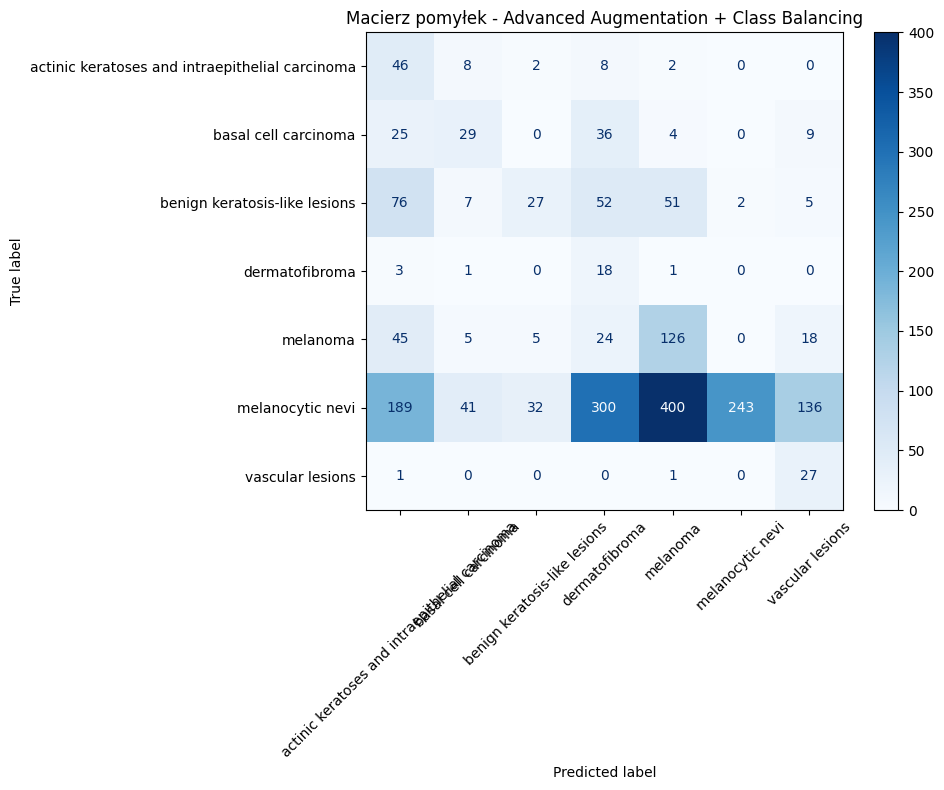


Najlepszy wynik F1-macro na zbiorze testowym: 0.2327


In [18]:
# Zadanie 6

EPOCHS = 30

# Advanced augmentation transform - FIXED ORDER
advanced_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.3),
    transforms.RandomRotation(15),
    transforms.RandomResizedCrop(size=28, scale=(0.8, 1.0), ratio=(0.9, 1.1)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.1, hue=0.02),
    transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.3),
    transforms.RandomGrayscale(p=0.1),
    transforms.ToTensor(),  # Convert to tensor BEFORE tensor-specific operations
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.2),
    transforms.RandomErasing(p=0.2, scale=(0.02, 0.1)),
    transforms.Lambda(lambda x: torch.clamp(x + 0.03 * torch.randn_like(x), -1, 1)),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Create datasets
train_set, val_set, test_set = make_datasets(advanced_transform)

# Compute class weights
weights_ce = compute_class_weights(train_set.labels)

# Create weighted sampler for training
train_labels = torch.tensor(np.array(train_set.labels).squeeze(), dtype=torch.long)
sample_weights = weights_ce[train_labels]

sampler = torch.utils.data.WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# Create data loaders
train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, sampler=sampler,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)

# Model, criterion and optimizer
criterion = nn.CrossEntropyLoss(weight=weights_ce.to(device))
model = SimpleCNN(NUM_CLASSES).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Training variables
best_f1 = 0.0
best_model_state = None

# Training loop
for epoch in range(1, EPOCHS + 1):
    # Train for one epoch
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)

    # Evaluate on validation set
    val_metrics, _, _ = evaluate(model, val_loader, device)

    # Calculate validation loss separately
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.squeeze().to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
    val_loss /= len(val_loader.dataset)

    # Check if this is the best model
    if val_metrics['f1_score'] > best_f1:
        best_f1 = val_metrics['f1_score']
        best_model_state = model.state_dict().copy()

    print(f"Epoka {epoch}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, val_f1={val_metrics['f1_score']:.3f}")

# Load best model and evaluate on test set
model.load_state_dict(best_model_state)
test_metrics, y_pred, y_true = evaluate(model, test_loader, device)

print("\n=== WYNIKI NA ZBIORZE TESTOWYM ===")
for metric, value in test_metrics.items():
    print(f"{metric}: {value:.4f}")

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=info['label'].values())
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Blues', xticks_rotation=45)
ax.set_title('Macierz pomyłek - Advanced Augmentation + Class Balancing')
plt.tight_layout()
plt.show()

print(f"\nNajlepszy wynik F1-macro na zbiorze testowym: {test_metrics['f1_score']:.4f}")

## Podsumowanie – Wnioski

- Która strategia **augmentacji** dała najwyższą Macro-F1?

  Baseline
- Czy **wagi** w CE lub **sampler** poprawiły Recall klas rzadkich?

Nie
- Jakie klasy najczęściej się mylą (macierz pomyłek)?

4-5 2-5